10.0%. Run time:  64.68s. Est. time left: 00:00:09:42
20.0%. Run time: 128.92s. Est. time left: 00:00:08:35
30.0%. Run time: 192.68s. Est. time left: 00:00:07:29
40.0%. Run time: 256.69s. Est. time left: 00:00:06:25
50.0%. Run time: 325.90s. Est. time left: 00:00:05:25
60.0%. Run time: 395.77s. Est. time left: 00:00:04:23
70.0%. Run time: 461.36s. Est. time left: 00:00:03:17
80.0%. Run time: 527.90s. Est. time left: 00:00:02:11
90.0%. Run time: 594.54s. Est. time left: 00:00:01:06
100.0%. Run time: 661.21s. Est. time left: 00:00:00:00
Total run time: 661.87s


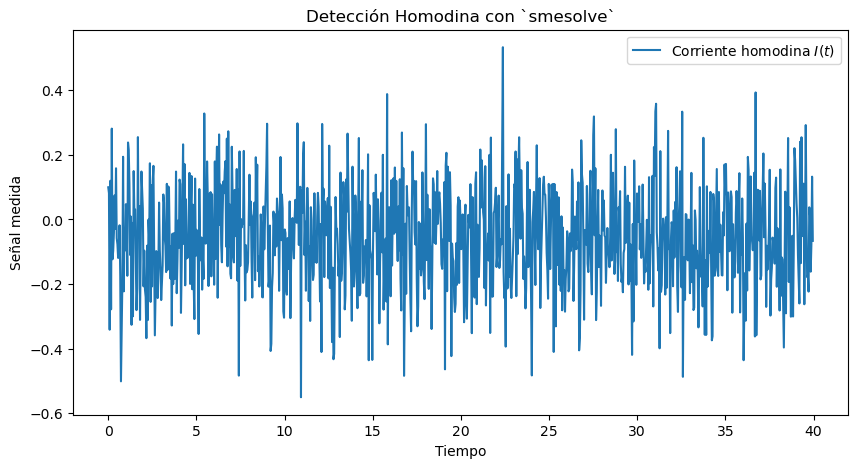

In [10]:
from qutip import basis, smesolve, destroy, sigmax
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
Omega = 1.0  # Frecuencia de Rabi
gamma = 1.0  # Tasa de emisión espontánea
phi = 0.0    # Fase del oscilador local

# Definir operadores
sm = destroy(2)  # Operador de aniquilación (sigma-)
sp = sm.dag()    # Operador de creación (sigma+)
sx = sigmax()    # Operador sigma-x
H = 0.5 * Omega * sx  # Hamiltoniano

# Estado inicial
psi0 = basis(2, 0)  # Inicializamos en |g⟩

# Operador de colapso con detección homodina
sigma_phi = (sp * np.exp(1j * phi) + sm * np.exp(-1j * phi)) / 2
collapse = [np.sqrt(gamma) * sigma_phi]

# Tiempo de simulación
tlist = np.linspace(0, 40, 1000)

# Opciones para `smesolve`
options = {"store_measurement": True}

# Simulación con `smesolve` usando detección homodina
result = smesolve(
    H, psi0, tlist, sc_ops=collapse, heterodyne=False, e_ops=[sp * sp.dag()], ntraj=1000, options=options
)

# Obtener fotocorriente medida
measurements = np.squeeze(result.measurement)  # Extraer datos
I_real = np.mean(measurements, axis=0)  # Promediar trayectorias

# Graficamos la corriente homodina
plt.figure(figsize=(10, 5))
plt.plot(tlist[:-1], I_real, label="Corriente homodina $I(t)$")
plt.xlabel("Tiempo")
plt.ylabel("Señal medida")
plt.title("Detección Homodina con `smesolve`")
plt.legend()
plt.show()


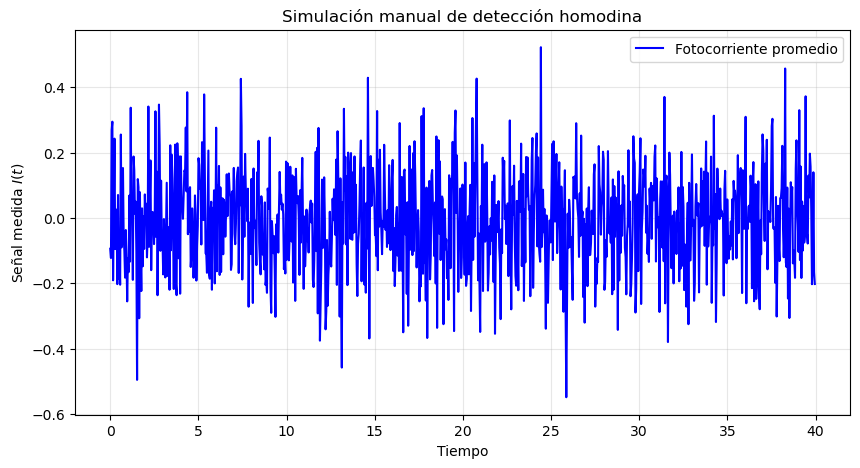

In [11]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros del sistema
gamma = 1.0          # Tasa de emisión espontánea
Omega = 1.0          # Frecuencia de Rabi
phi = 0.0            # Fase del oscilador local
t_max = 40           # Tiempo de simulación
dt = 0.04            # Paso de tiempo
steps = int(t_max / dt)  # Número de pasos
num_traj = 1000        # Número de trayectorias

# Operadores cuánticos
sm = qt.destroy(2)   # Operador sigma-
sp = sm.dag()        # Operador sigma+
sigma_x = qt.sigmax()
sigma_phi = (sp * np.exp(1j * phi) + sm * np.exp(-1j * phi)) / 2

# Hamiltoniano
H_sys = 0.5 * Omega * sigma_x

# Función para simular una trayectoria homodina
def simulate_homodyne():
    psi_t = qt.basis(2, 0)  # Estado inicial |g⟩
    I_t = []  # Fotocorriente medida
    times = np.linspace(0, t_max, steps)
    
    for i in range(steps):
        # Valor esperado de sigma_phi
        sigma_phi_expect = qt.expect(sigma_phi, psi_t)
        
        # Ruido de Wiener
        dW = np.sqrt(dt) * np.random.randn()
        
        # Hamiltoniano con retroalimentación de medición
        H_feedback = -1j * np.sqrt(gamma) * sigma_phi_expect * sm
        H_total = H_sys + H_feedback
        
        # Evolución del estado con Euler-Maruyama
        dpsi = (-1j * H_total * psi_t - 0.5 * gamma * sm.dag() * sm * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        
        # Fotocorriente homodina
        I_t.append(2 * np.sqrt(gamma) * sigma_phi_expect + dW / dt)
    
    return times[:-1], I_t[:steps-1]

# Simular múltiples trayectorias
all_currents = np.zeros((num_traj, steps-1))
for k in range(num_traj):
    t, I_t = simulate_homodyne()
    all_currents[k, :] = I_t

# Promedio de trayectorias
I_avg = np.mean(all_currents, axis=0)

# Graficar fotocorriente promedio
plt.figure(figsize=(10, 5))
plt.plot(t, I_avg, 'b-', label="Fotocorriente promedio")
plt.xlabel("Tiempo")
plt.ylabel("Señal medida $I(t)$")
plt.title("Simulación manual de detección homodina")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


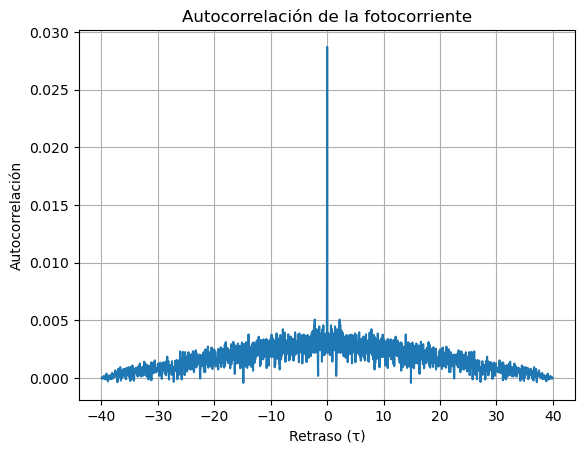

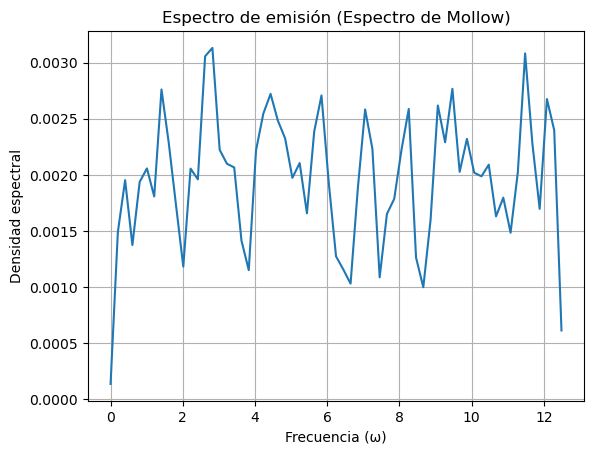

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, welch

# Supongamos que I_t es tu fotocorriente simulada y tlist es el tiempo
I_t = np.array(I_real)  # Fotocorriente simulada
dt = tlist[1] - tlist[0]  # Paso de tiempo

# Calcular la autocorrelación (normalizada)
R_tau = correlate(I_t, I_t, mode='full') / len(I_t)
lags = np.arange(-len(I_t) + 1, len(I_t)) * dt  # Escala de tiempo para tau

# Espectro de emisión (transformada de Fourier de la autocorrelación)
freqs, S_w = welch(I_t, fs=1/dt, nperseg=len(I_t)//8)

# Graficar autocorrelación
plt.figure()
plt.plot(lags, R_tau)
plt.xlabel("Retraso (τ)")
plt.ylabel("Autocorrelación")
plt.title("Autocorrelación de la fotocorriente")
plt.grid()

# Graficar espectro de emisión
plt.figure()
plt.plot(freqs, S_w)
plt.xlabel("Frecuencia (ω)")
plt.ylabel("Densidad espectral")
plt.title("Espectro de emisión (Espectro de Mollow)")
plt.grid()
plt.show()


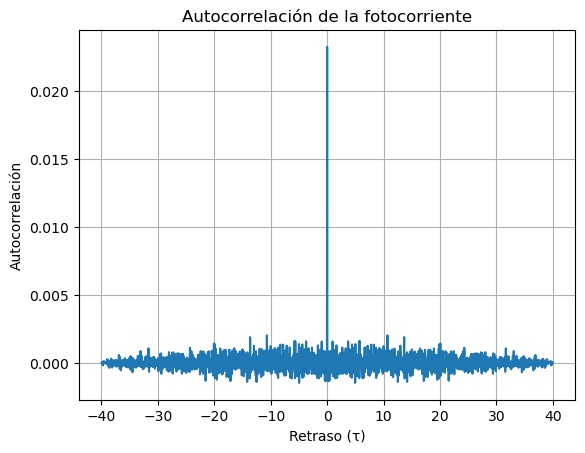

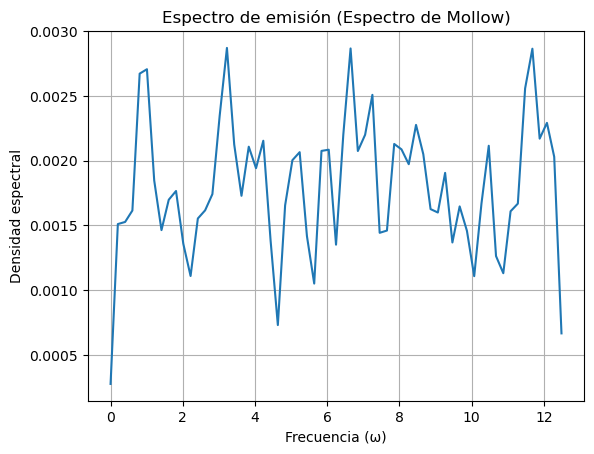

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, welch

# Supongamos que I_t es tu fotocorriente simulada y tlist es el tiempo
I_t = np.array(I_avg)  # Fotocorriente simulada
dt = tlist[1] - tlist[0]  # Paso de tiempo

# Calcular la autocorrelación (normalizada)
R_tau = correlate(I_t, I_t, mode='full') / len(I_t)
lags = np.arange(-len(I_t) + 1, len(I_t)) * dt  # Escala de tiempo para tau

# Espectro de emisión (transformada de Fourier de la autocorrelación)
freqs, S_w = welch(I_t, fs=1/dt, nperseg=len(I_t)//8)

# Graficar autocorrelación
plt.figure()
plt.plot(lags, R_tau)
plt.xlabel("Retraso (τ)")
plt.ylabel("Autocorrelación")
plt.title("Autocorrelación de la fotocorriente")
plt.grid()

# Graficar espectro de emisión
plt.figure()
plt.plot(freqs, S_w)
plt.xlabel("Frecuencia (ω)")
plt.ylabel("Densidad espectral")
plt.title("Espectro de emisión (Espectro de Mollow)")
plt.grid()
plt.show()
